# KAN-ODE

In [1]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [2]:
import time
start_time = time.time()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd
from base_kan.ekan import EKAN 

In [ ]:

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta

    def forward(self, t, y):
        S, I, R, A= y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = -abs(neural_output)
        dA_dt = abs(neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])


In [ ]:

gamma = 0.05
beta = 0.12
neural_ode_func = SimpleMLP()
tmodel = CustomSIRSystem(neural_ode_func, gamma, beta)

In [ ]:
intial = 0.  ##
last= 40.    ##
step = 40    ##
y0 = torch.tensor([0.99, 0.01, 0.0, 0.0], requires_grad=True)  # 
t = torch.linspace(intial, last, step)  # 

In [7]:
def get_data():
    gamma = 0.05
    beta = 0.12
    a = 0.5
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * torch.exp(-a*I) * I
        dI_dt = beta * S * torch.exp(-a*I) * I  - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * torch.exp(-a*I) * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

In [8]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 3] - true_y[:, 3]) ** 2)

In [9]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 3] - true_y[:, 3])
    correct = (diff < threshold).float().mean()
    return correct.item()

In [10]:
def train():
    optimizer = optim.Adam(tmodel.parameters(), lr=1e-4)

    for itr in range(2000):
        optimizer.zero_grad()
        pred_y = odeint(tmodel, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y

In [11]:
t, true_y, pred_y = train()

Iter 0, Loss: 0.09445089846849442, Accuracy: 2.50%
Iter 100, Loss: 0.0010104618268087506, Accuracy: 12.50%
Iter 200, Loss: 0.0009425967000424862, Accuracy: 15.00%
Iter 300, Loss: 0.000874706543982029, Accuracy: 15.00%
Iter 400, Loss: 0.0008102789288386703, Accuracy: 15.00%
Iter 500, Loss: 0.0007504108361899853, Accuracy: 15.00%
Iter 600, Loss: 0.0006931439274922013, Accuracy: 15.00%
Iter 700, Loss: 0.00063687952933833, Accuracy: 17.50%
Iter 800, Loss: 0.0005801106453873217, Accuracy: 17.50%
Iter 900, Loss: 0.0005215954734012485, Accuracy: 17.50%
Iter 1000, Loss: 0.00046158116310834885, Accuracy: 20.00%
Iter 1100, Loss: 0.00040026375791057944, Accuracy: 22.50%
Iter 1200, Loss: 0.00033859212999232113, Accuracy: 22.50%
Iter 1300, Loss: 0.0002778143680188805, Accuracy: 25.00%
Iter 1400, Loss: 0.00022010912653058767, Accuracy: 32.50%
Iter 1500, Loss: 0.00016712282376829535, Accuracy: 35.00%
Iter 1600, Loss: 0.00012075348058715463, Accuracy: 45.00%
Iter 1700, Loss: 8.267538214568049e-05, Acc

In [ ]:
def forword_CF(x):
   
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    #
    result = x.clone().detach()
    
    result[1:] = x[1:] - x[:-1]
    
    return result

In [13]:
true_y[:,3] = forword_CF(true_y[:,3])
pred_y[:,3] = forword_CF(pred_y[:,3])

/tmp/ipykernel_896088/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [14]:
a=0.4
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1]*100,
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
    'True_A': true_y.numpy()[:, 3],
    'Predicted_A': pred_y.detach().numpy()[:, 3],
    'Symbol_I': 0.4*torch.exp(-a*pred_y[:, 1]*100).detach().numpy()
}
df = pd.DataFrame(data)


In [15]:
df.to_excel('Q-E-a-0.5mlp.xlsx', index=False)

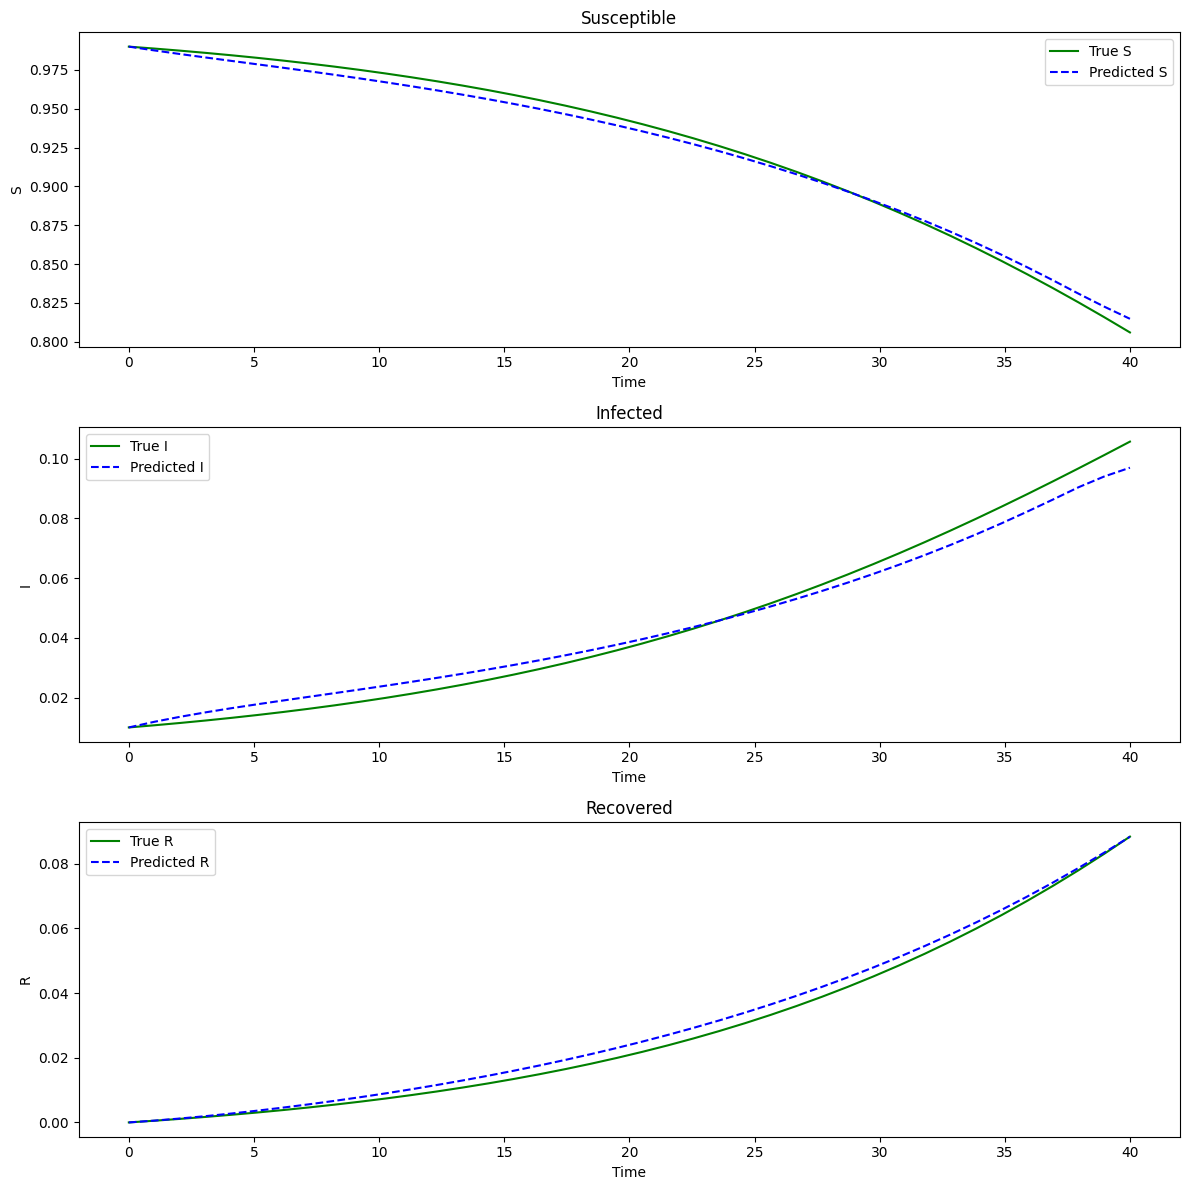

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('Q-E-a-0.5_SIRmlp.png')
plt.show()


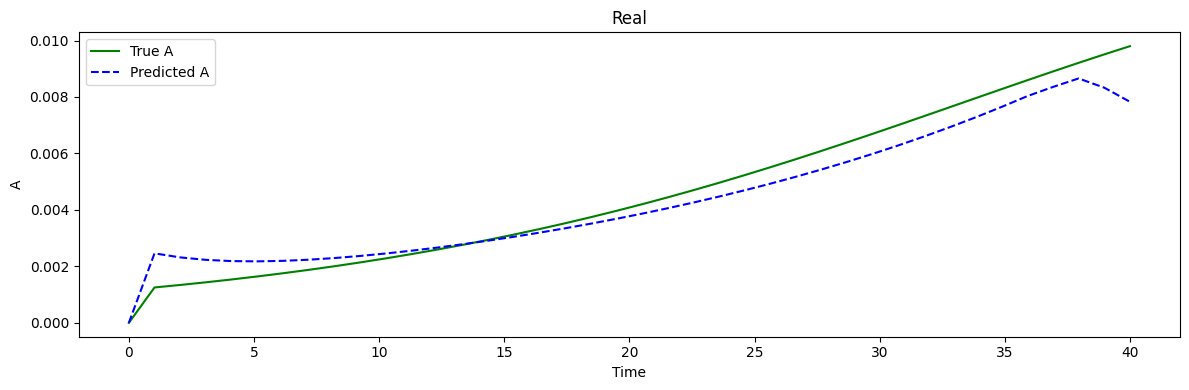

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(t.numpy(), true_y.numpy()[:, 3], 'g-', label='True A')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 3], 'b--', label='Predicted A')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')

plt.tight_layout()
plt.savefig('Q-E-a-0.5_truemlp.png')
plt.show()

In [ ]:

extend = 40
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)#

In [19]:
def get_data():
    gamma = 0.05
    beta = 0.12
    a = 0.5
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * torch.exp(-a*I) * I
        dI_dt = beta * S * torch.exp(-a*I) * I  - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * torch.exp(-a*I) * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, in_true_y = get_data()

In [20]:
def get_data():
    gamma = 0.05
    beta = 0.12
    a = 0.5
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * torch.exp(-a*I) * I
        dI_dt = beta * S * torch.exp(-a*I) * I  - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * torch.exp(-a*I) * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        in_true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return in_t, in_true_y

in_t, in_NH_true_y = get_data()

In [21]:
with torch.no_grad():
    in_pred_y = odeint(tmodel, y0, in_t, rtol=1e-5, atol=1e-8)

In [ ]:
def forword_CF(x):
    
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
   
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
  
    result = x.clone().detach()
    
  
    result[1:] = x[1:] - x[:-1]
    
    return result

In [23]:
in_true_y[:,3] = forword_CF(in_true_y[:,3])
in_pred_y[:,3] = forword_CF(in_pred_y[:,3])
in_NH_true_y[:,3] = forword_CF(in_NH_true_y[:,3])

/tmp/ipykernel_896088/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [24]:
in_data = {
    'Time': in_t.numpy(),
    'True_S': in_true_y.numpy()[:, 0],
    'Equation_S': in_NH_true_y.numpy()[:, 0],
    'Predicted_S': in_pred_y.detach().numpy()[:, 0],
    'True_I': in_true_y.numpy()[:, 1],
    'Equation_I': in_NH_true_y.numpy()[:, 1],
    'Predicted_I': in_pred_y.detach().numpy()[:, 1],
    'True_R': in_true_y.numpy()[:, 2],
    'Equation R': in_NH_true_y.numpy()[:, 2],
    'Predicted_R': in_pred_y.detach().numpy()[:, 2],
    'True_A': in_true_y.numpy()[:, 3],
    'Equation A': in_NH_true_y.numpy()[:, 3],
    'Predicted_A': in_pred_y.detach().numpy()[:, 3],
}
in_df = pd.DataFrame(in_data)
in_df.to_excel('in_Q-E-a-0.5mlp.xlsx', index=False)

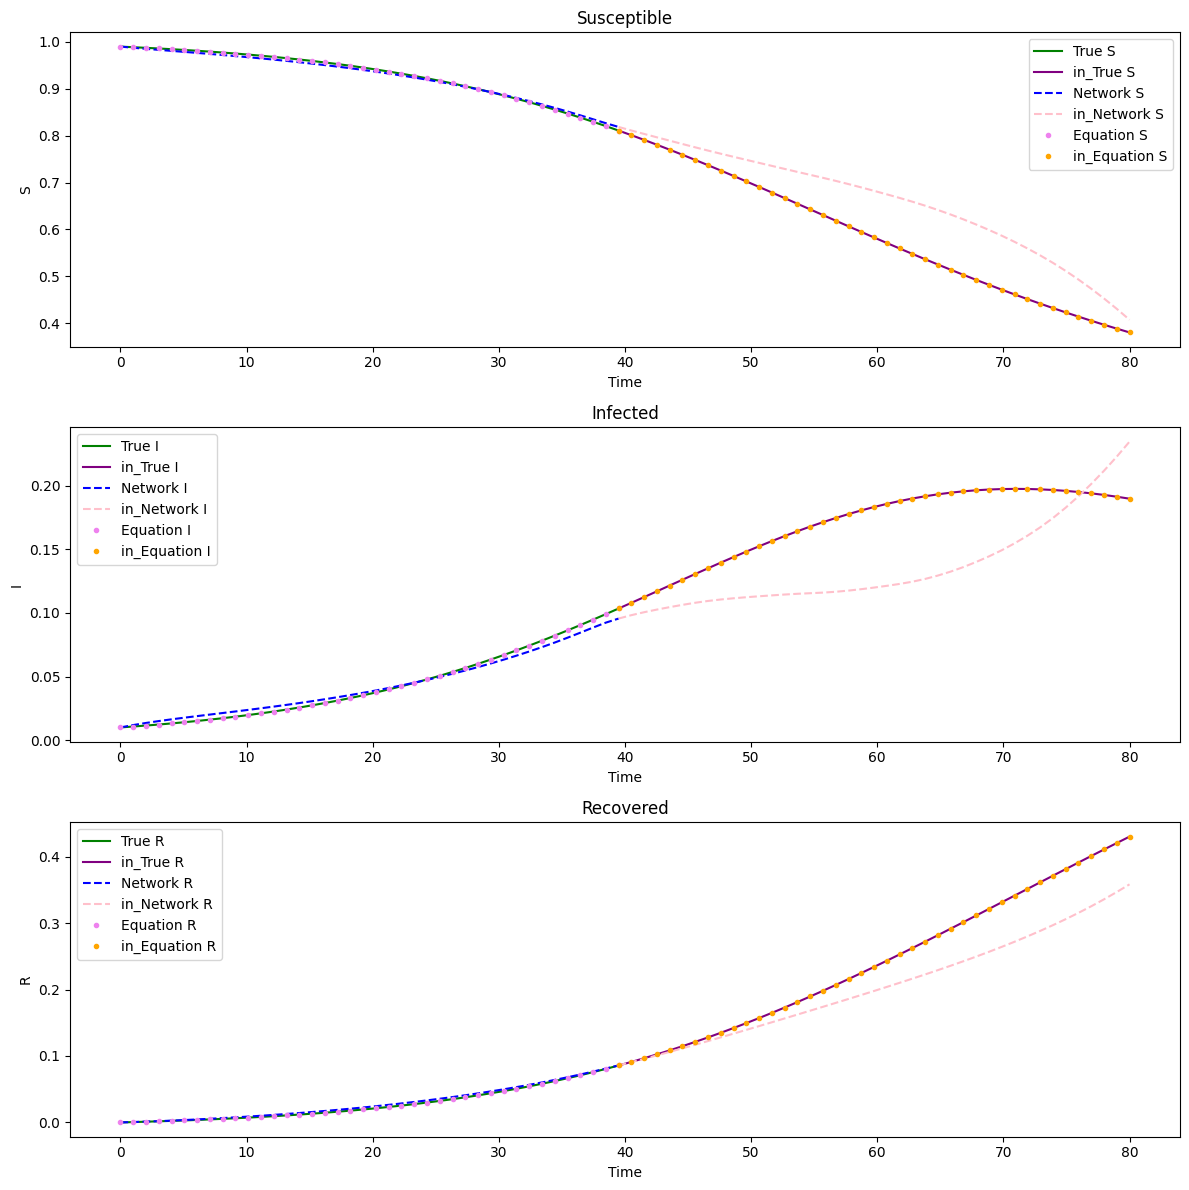

In [25]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 0], '-', label='True S', color = 'green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 0], '-', label='in_True S', color = 'purple')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 0], '--', label='Network S', color = 'blue')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 0], '--', label='in_Network S', color = 'pink')
plt.plot(in_t.numpy()[:last], in_NH_true_y.numpy()[:last, 0], '.', label='Equation S', color = 'violet')
plt.plot(in_t.numpy()[last-1:timeend], in_NH_true_y.detach().numpy()[last-1:timeend, 0], '.', label='in_Equation S', color = 'orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 1], '-', label='True I', color = 'green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 1], '-', label='in_True I', color = 'purple')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 1], '--', label='Network I', color = 'blue')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 1], '--', label='in_Network I', color = 'pink')
plt.plot(in_t.numpy()[:last], in_NH_true_y.numpy()[:last, 1], '.', label='Equation I', color = 'violet')
plt.plot(in_t.numpy()[last-1:timeend], in_NH_true_y.detach().numpy()[last-1:timeend, 1], '.', label='in_Equation I', color = 'orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 2], '-', label='True R', color = 'green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 2], '-', label='in_True R', color = 'purple')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 2], '--', label='Network R', color = 'blue')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 2], '--', label='in_Network R', color = 'pink')
plt.plot(in_t.numpy()[:last], in_NH_true_y.numpy()[:last, 2], '.', label='Equation R', color = 'violet')
plt.plot(in_t.numpy()[last-1:timeend], in_NH_true_y.detach().numpy()[last-1:timeend, 2], '.', label='in_Equation R', color = 'orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('in_Q-E-a-0.5_SIRmlp.png')
plt.show()

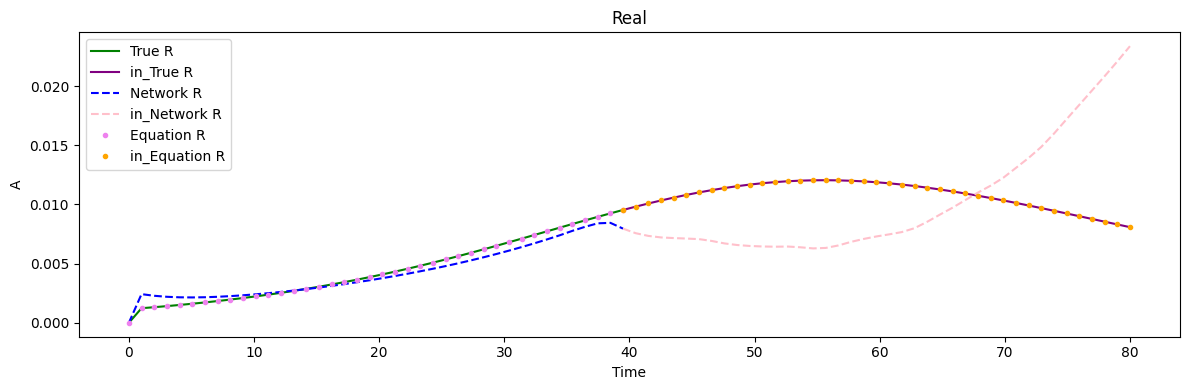

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 3], '-', label='True R', color = 'green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 3], '-', label='in_True R', color = 'purple')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 3], '--', label='Network R', color = 'blue')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 3], '--', label='in_Network R', color = 'pink')
plt.plot(in_t.numpy()[:last], in_NH_true_y.numpy()[:last, 3], '.', label='Equation R', color = 'violet')
plt.plot(in_t.numpy()[last-1:timeend], in_NH_true_y.detach().numpy()[last-1:timeend, 3], '.', label='in_Equation R', color = 'orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')
plt.tight_layout()
plt.savefig('in_Q-E-a-0.5_truemlp.png')
plt.show()